### Home work 3
###### your_student_id

The goal of this home work is to design convolutional neural network for classification task on two dataset (a) cifar10 (b) Bricklane. As a part of this home work you will implement convolutional neural network in python and then study the effect of pooling, dropout, batch normalization and learning rate for given classifcation task. 
<br>
Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 




#### imports

In [1]:
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K
from keras.datasets import cifar10
import keras

from sklearn.model_selection import train_test_split
from IPython.display import display

import csv
import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#import seaborn as sns

import os
your_id = 20110126
np.random.seed(your_id)


Using TensorFlow backend.


In [2]:
simple_model = pd.read_csv('simple_model/logs.csv')
pre_norm = pd.read_csv('pre_norm/logs.csv')
pooling = pd.read_csv('pooling/logs.csv')
dropout = pd.read_csv('dropout/logs.csv')
batch_norm = pd.read_csv('batch_norm/logs.csv')

###### Hyperparameters

In [3]:
batch_size = 16
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape = (32,32,3)
dir_main = 'cifar/'
dir_train = 'cifar/train'
dir_test = 'cifar/test'

##### Task 1.1   Load dataset information
[_cifar10_](https://www.cs.toronto.edu/~kriz/cifar.html) dataset contains 10 classes including airplane, bird, cat etc. You need to download dataset from [LINK](http://pjreddie.com/media/files/cifar.tgz) or [LINK2](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz). 
<br> _cifar10_ dataset is also available in keras but it is recommended to use the downloaded from above given link as ```cifar10.load_data()``` function downloads and loads complete data on RAM. 
<br> <br>
This [Github](https://github.com/EN10/CIFAR) link may be helpful to you to load _cifar10_ dataset yourself.


In [14]:
#Getting paths for all images in training set

path_images = os.listdir(dir_train)

In [4]:
#reading in class names

labels_file = open('cifar/labels.txt')
labels = labels_file.read()
labels = labels.split('\n')
class_names = labels[:-1]
print ('class_names:', class_names)
print ('number of classes:', len(class_names))

In [16]:
# Arranging classes in order so we can attach labels accordingly
# class 1 = 0-5000
# class 2 = 5001-10000 and so on

import glob
paths = []
labels = []

for i in range(len(class_names)):
    path = glob.glob(dir_train +'/*' + class_names[i] + '.png')
    for r in range(len(path)):
        labels.append(i)
    paths += (path)        


In [17]:
for i in range(len(paths)):
    if i % 5000 == 0:
        print (paths[i+1],"  & Label= ", labels[i+1])

cifar/train/42179_airplane.png   & Label=  0
cifar/train/22394_automobile.png   & Label=  1
cifar/train/6917_bird.png   & Label=  2
cifar/train/45066_cat.png   & Label=  3
cifar/train/48309_deer.png   & Label=  4
cifar/train/7873_dog.png   & Label=  5
cifar/train/4062_frog.png   & Label=  6
cifar/train/42550_horse.png   & Label=  7
cifar/train/49897_ship.png   & Label=  8
cifar/train/31068_truck.png   & Label=  9


In [18]:
x_train ,x_val, y_train, y_val = train_test_split(paths, labels, test_size=0.2, random_state=your_id)

print(len(x_train), 'train samples')
print(len(x_val), 'validation samples')

40000 train samples
10000 validation samples


##### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelrate the training process. 

###### Task 1.2.1 
For the images, pixel values vary from 0 to 255. To shift the values between (0,1) range, divide input image by 255. Now, retrain the model designed in part-A from scratch with preprocessed data. 

In [19]:
# You shall add your code here
#shape(images) = (64,32,32,3)

def preprocessing_norm (images):
    #print (images.shape)
    processed_images = np.zeros(shape=(images.shape[0],32,32,3))
    processed_images[:,:,:,:] = images[:,:,:,:]/255
    return processed_images


###### Task 1.2.2
For the images, pixel values vary from 0 to 255. Compute the channel wise mean and standard daviation (std) for whole dataset. subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and varation to 1. 

In [20]:
def preprocessing_meanShift (images):
    means = []
    stdevs = []
    processed_images = np.zeros(shape=(images.shape[0],32,32,3))
    
    for i in range(3):
        mean = np.mean(images[:,:,:,i])
        std = np.std(images[:,:,:,i])
        means.append(mean)
        stdevs.append(std)
        
    for i in range(3):
        processed_images[:,:,:,i] = ((images[:,:,:,i] - means[i])/ stdevs[i])
    
    return processed_images


##### Task 1.3  Batch Generator
For the training, we load complete data (inputs, outputs) into RAM and then provide it to "model.fit" function. However, in real when dataset is very large in size we can not load complete data on RAM. In that case, we need load data batchwise. To do this, we need to write a generator function that shall load a batch of data (images and output), preprocess images and return a tuple as (inputs, outputs) on every step. 
<br>
- The template code for batch generator is provided. You need add you script to read image(s), labels and preprocessing of images. 
<br>
- You need to check and control values of batch_start and batch_end 
<br>
- Batch generator can be implemented in multiple ways. You can use any other template of your choice.

In [21]:
def data_generator(images_paths,label_file, batch_size = 64, preprocessing = None):
    #batch_start = 0
    #batch_end = len(images_paths)
    
    
    indexes = np.arange(0,len(images_paths), batch_size)
    
    if len(images_paths) % batch_size != 0:
        indexes = indexes[:-1] 
    
    counter = 0
    
    while True:
        np.random.shuffle(indexes)
        for index in indexes:
            
            paths = images_paths[index : index + batch_size]
            labels = label_file[index : index + batch_size]

            
            x_array = np.zeros((batch_size,32,32,3))
            y_array = np.zeros((batch_size,10))
            
            for i in range(len(paths)):
                x_array[i] = cv2.imread(paths[i])
            
            batch_labels = to_categorical(labels, num_classes = 10)
              
            batch_images = x_array
            if (preprocessing is None):
                pass
            elif (preprocessing == 'method1'):
                batch_images = preprocessing_norm(batch_images)
            else:
                batch_images = preprocessing_meanShift(batch_images)
            
            batch_x = np.array( batch_images )
            batch_y = np.array( batch_labels )
            yield( batch_x, batch_y )
          
        

##### Task 1.4 Design CNN model

In [22]:
# Add your code here

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_im, outputs=output_class)


##### Compile model and plot

In [ ]:
model_name = 'simple_model'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

#plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

##### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [23]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [24]:
epochs = 200
    
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
#reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

###### Task 1.5.1 
Train model without using any pre-processing scheme

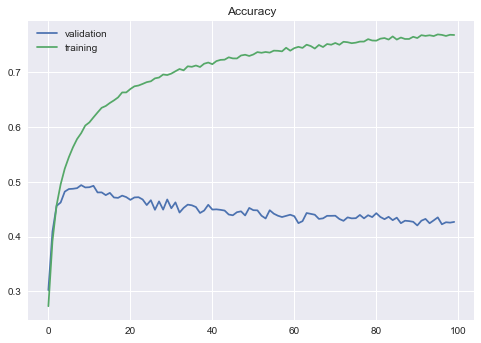

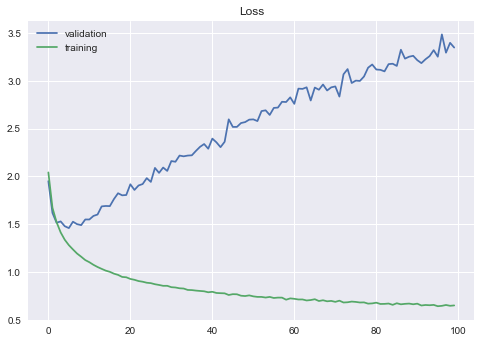

In [45]:
x_axis = list(range(100))

plt.clf() 
plt.plot(x_axis, simple_model['val_acc'][0:100], label='validation')
plt.plot(x_axis, simple_model['acc'][0:100], label='training')
plt.legend()
plt.title('Accuracy')
plt.show()


plt.clf() 
plt.plot(x_axis, simple_model['val_loss'][0:100], label='validation')
plt.plot(x_axis, simple_model['loss'][0:100], label='training')
plt.legend()
plt.title('Loss')
plt.show()

In [15]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

In [16]:
x,y= val_gen.__next__()

In [17]:
hist_simple = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

model.save(model_name + '.h5')

Epoch 1/100
2500/2500 [==============================] - 26s 11ms/step - loss: 2.0418 - acc: 0.2732 - val_loss: 1.9507 - val_acc: 0.3025

Epoch 00001: val_loss improved from inf to 1.95067, saving model to simple_model/simple_model-01-1.95.h5
Epoch 2/100
2500/2500 [==============================] - 22s 9ms/step - loss: 1.6721 - acc: 0.3917 - val_loss: 1.6183 - val_acc: 0.4089

Epoch 00002: val_loss improved from 1.95067 to 1.61832, saving model to simple_model/simple_model-02-1.62.h5
Epoch 3/100
2500/2500 [==============================] - 22s 9ms/step - loss: 1.5221 - acc: 0.4568 - val_loss: 1.5162 - val_acc: 0.4559

Epoch 00003: val_loss improved from 1.61832 to 1.51620, saving model to simple_model/simple_model-03-1.52.h5
Epoch 4/100
2500/2500 [==============================] - 22s 9ms/step - loss: 1.4148 - acc: 0.4953 - val_loss: 1.5298 - val_acc: 0.4621

Epoch 00004: val_loss did not improve from 1.51620
Epoch 5/100
2500/2500 [==============================] - 23s 9ms/step - loss:

2500/2500 [==============================] - 16s 6ms/step - loss: 0.7795 - acc: 0.7218 - val_loss: 2.3060 - val_acc: 0.4487

Epoch 00043: val_loss did not improve from 1.45984
Epoch 44/100
2500/2500 [==============================] - 16s 6ms/step - loss: 0.7779 - acc: 0.7222 - val_loss: 2.3621 - val_acc: 0.4474

Epoch 00044: val_loss did not improve from 1.45984
Epoch 45/100
2500/2500 [==============================] - 16s 7ms/step - loss: 0.7606 - acc: 0.7265 - val_loss: 2.5968 - val_acc: 0.4402

Epoch 00045: val_loss did not improve from 1.45984
Epoch 46/100
2500/2500 [==============================] - 16s 7ms/step - loss: 0.7693 - acc: 0.7245 - val_loss: 2.5176 - val_acc: 0.4388

Epoch 00046: val_loss did not improve from 1.45984
Epoch 47/100
2500/2500 [==============================] - 16s 7ms/step - loss: 0.7681 - acc: 0.7244 - val_loss: 2.5179 - val_acc: 0.4444

Epoch 00047: val_loss did not improve from 1.45984
Epoch 48/100
2500/2500 [==============================] - 16s 7ms/st

###### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [16]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'method1')
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()

In [17]:
model = None

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model = Model(inputs=input_im, outputs=output_class)

# save model

In [18]:
model_name = 'pre_norm'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

#plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_________________________________________________________________


In [19]:
hist_pre_norm = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

model.save(model_name + '.h5')

Epoch 1/100
2500/2500 [==============================] - 36s 14ms/step - loss: 1.6666 - acc: 0.3951 - val_loss: 9.7509 - val_acc: 0.3872

Epoch 00001: val_loss improved from inf to 9.75088, saving model to pre_norm/pre_norm-01-9.75.h5
Epoch 2/100
2500/2500 [==============================] - 28s 11ms/step - loss: 1.3730 - acc: 0.5073 - val_loss: 9.3413 - val_acc: 0.4115

Epoch 00002: val_loss improved from 9.75088 to 9.34127, saving model to pre_norm/pre_norm-02-9.34.h5
Epoch 3/100
2500/2500 [==============================] - 26s 10ms/step - loss: 1.2804 - acc: 0.5415 - val_loss: 9.5740 - val_acc: 0.3989

Epoch 00003: val_loss did not improve from 9.34127
Epoch 4/100
2500/2500 [==============================] - 25s 10ms/step - loss: 1.2182 - acc: 0.5682 - val_loss: 9.1557 - val_acc: 0.4256

Epoch 00004: val_loss improved from 9.34127 to 9.15574, saving model to pre_norm/pre_norm-04-9.16.h5
Epoch 5/100
2500/2500 [==============================] - 21s 8ms/step - loss: 1.1648 - acc: 0.5832

2500/2500 [==============================] - 19s 8ms/step - loss: 0.5616 - acc: 0.7974 - val_loss: 10.1357 - val_acc: 0.3691

Epoch 00086: val_loss did not improve from 9.15574
Epoch 87/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.5625 - acc: 0.7951 - val_loss: 10.0277 - val_acc: 0.3754

Epoch 00087: val_loss did not improve from 9.15574
Epoch 88/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.5573 - acc: 0.7987 - val_loss: 9.9697 - val_acc: 0.3787

Epoch 00088: val_loss did not improve from 9.15574
Epoch 89/100
2500/2500 [==============================] - 19s 7ms/step - loss: 0.5589 - acc: 0.7971 - val_loss: 10.0380 - val_acc: 0.3747

Epoch 00089: val_loss did not improve from 9.15574
Epoch 90/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.5554 - acc: 0.7982 - val_loss: 10.0459 - val_acc: 0.3741

Epoch 00090: val_loss did not improve from 9.15574
Epoch 91/100
2500/2500 [==============================] - 19s 7m

##### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using __fit_generator__ function. 

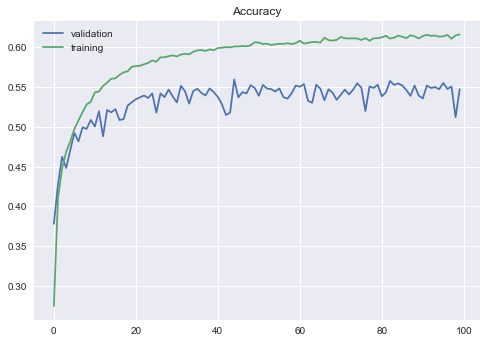

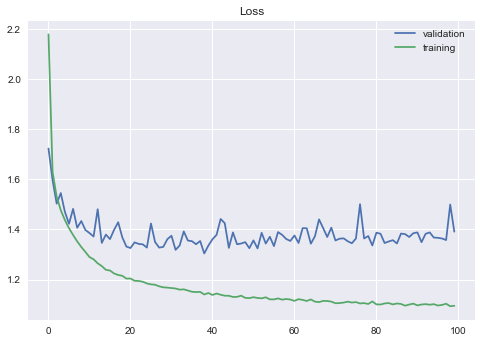

In [39]:
x_axis = list(range(100))

plt.clf() 
plt.plot(x_axis, pooling['val_acc'][0:100], label='validation')
plt.plot(x_axis, pooling['acc'][0:100], label='training')
plt.legend()
plt.title('Accuracy')
plt.show()


plt.clf() 
plt.plot(x_axis, pooling['val_loss'][0:100], label='validation')
plt.plot(x_axis, pooling['loss'][0:100], label='training')
plt.legend()
plt.title('Loss')
plt.show()

In [16]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()

In [34]:
model = None

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
pooling1 = AveragePooling2D(pool_size=(2,2), padding='same')(conv1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pooling1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)
model = Model(inputs=input_im, outputs=output_class)


# save model

In [35]:
model_name = 'pooling'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

#plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
average_pooling2d_3 (Average (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
flatten_2 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 44)                6380      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                450       
Total para

In [19]:
#1 pooling layer #better

hist_pooling = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

model.save(model_name + '.h5')

Epoch 1/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.1772 - acc: 0.2746 - val_loss: 1.7224 - val_acc: 0.3782

Epoch 00001: val_loss improved from inf to 1.72237, saving model to pooling/pooling-01-1.72.h5
Epoch 2/100
2500/2500 [==============================] - 17s 7ms/step - loss: 1.6284 - acc: 0.4105 - val_loss: 1.5957 - val_acc: 0.4276

Epoch 00002: val_loss improved from 1.72237 to 1.59571, saving model to pooling/pooling-02-1.60.h5
Epoch 3/100
2500/2500 [==============================] - 17s 7ms/step - loss: 1.5299 - acc: 0.4475 - val_loss: 1.5026 - val_acc: 0.4626

Epoch 00003: val_loss improved from 1.59571 to 1.50263, saving model to pooling/pooling-03-1.50.h5
Epoch 4/100
2500/2500 [==============================] - 16s 6ms/step - loss: 1.4764 - acc: 0.4686 - val_loss: 1.5449 - val_acc: 0.4485

Epoch 00004: val_loss did not improve from 1.50263
Epoch 5/100
2500/2500 [==============================] - 16s 7ms/step - loss: 1.4373 - acc: 0.4820 - val_los


Epoch 00040: val_loss did not improve from 1.30413
Epoch 41/100
2500/2500 [==============================] - 23s 9ms/step - loss: 1.1387 - acc: 0.5993 - val_loss: 1.3607 - val_acc: 0.5379

Epoch 00041: val_loss did not improve from 1.30413
Epoch 42/100
2500/2500 [==============================] - 23s 9ms/step - loss: 1.1443 - acc: 0.5997 - val_loss: 1.3782 - val_acc: 0.5286

Epoch 00042: val_loss did not improve from 1.30413
Epoch 43/100
2500/2500 [==============================] - 23s 9ms/step - loss: 1.1395 - acc: 0.6005 - val_loss: 1.4415 - val_acc: 0.5150

Epoch 00043: val_loss did not improve from 1.30413
Epoch 44/100
2500/2500 [==============================] - 24s 9ms/step - loss: 1.1357 - acc: 0.6002 - val_loss: 1.4247 - val_acc: 0.5182

Epoch 00044: val_loss did not improve from 1.30413
Epoch 45/100
2500/2500 [==============================] - 24s 10ms/step - loss: 1.1355 - acc: 0.6013 - val_loss: 1.3263 - val_acc: 0.5597

Epoch 00045: val_loss did not improve from 1.30413
Ep

2500/2500 [==============================] - 22s 9ms/step - loss: 1.1063 - acc: 0.6123 - val_loss: 1.3519 - val_acc: 0.5530

Epoch 00084: val_loss did not improve from 1.30413
Epoch 85/100
2500/2500 [==============================] - 22s 9ms/step - loss: 1.1011 - acc: 0.6149 - val_loss: 1.3571 - val_acc: 0.5548

Epoch 00085: val_loss did not improve from 1.30413
Epoch 86/100
2500/2500 [==============================] - 17s 7ms/step - loss: 1.1047 - acc: 0.6134 - val_loss: 1.3440 - val_acc: 0.5522

Epoch 00086: val_loss did not improve from 1.30413
Epoch 87/100
2500/2500 [==============================] - 17s 7ms/step - loss: 1.1028 - acc: 0.6118 - val_loss: 1.3834 - val_acc: 0.5464

Epoch 00087: val_loss did not improve from 1.30413
Epoch 88/100
2500/2500 [==============================] - 17s 7ms/step - loss: 1.0959 - acc: 0.6154 - val_loss: 1.3812 - val_acc: 0.5391

Epoch 00088: val_loss did not improve from 1.30413
Epoch 89/100
2500/2500 [==============================] - 17s 7ms/st

##### Task 3.1 Dropout
Modify the network by introducing dropout layer and train the model using __fit_generator__ function. 

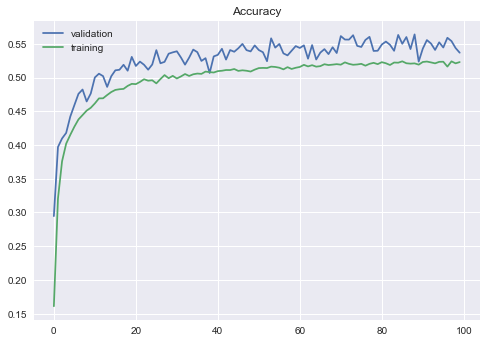

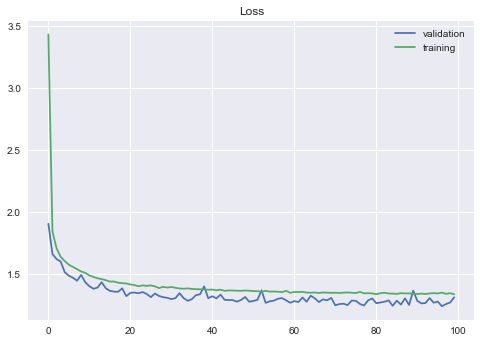

In [40]:
x_axis = list(range(100))

plt.clf() 
plt.plot(x_axis, dropout['val_acc'][0:100], label='validation')
plt.plot(x_axis, dropout['acc'][0:100], label='training')
plt.legend()
plt.title('Accuracy')
plt.show()


plt.clf() 
plt.plot(x_axis, dropout['val_loss'][0:100], label='validation')
plt.plot(x_axis, dropout['loss'][0:100], label='training')
plt.legend()
plt.title('Loss')
plt.show()

In [16]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()

In [17]:
model = None

input_im = Input(shape=(input_shape), name='input_im')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
dropout1 = Dropout(0.2)(conv1)
pooling1 = AveragePooling2D(pool_size=(2,2), padding='same')(dropout1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pooling1)
dropout3 = Dropout(0.2)(conv2)
flat = Flatten()(dropout3)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)
model = Model(inputs=input_im, outputs=output_class)


# save model

In [18]:
model_name = 'dropout'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

#plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 8)         0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 144)               0         
__________

In [19]:
#2 dropout
hist_dropout = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

model.save(model_name + '.h5')

Epoch 1/100
2500/2500 [==============================] - 31s 13ms/step - loss: 3.4313 - acc: 0.1610 - val_loss: 1.9073 - val_acc: 0.2946

Epoch 00001: val_loss improved from inf to 1.90733, saving model to dropout/dropout-01-1.91.h5
Epoch 2/100
2500/2500 [==============================] - 29s 12ms/step - loss: 1.8442 - acc: 0.3206 - val_loss: 1.6637 - val_acc: 0.3970

Epoch 00002: val_loss improved from 1.90733 to 1.66365, saving model to dropout/dropout-02-1.66.h5
Epoch 3/100
2500/2500 [==============================] - 30s 12ms/step - loss: 1.7103 - acc: 0.3759 - val_loss: 1.6230 - val_acc: 0.4097

Epoch 00003: val_loss improved from 1.66365 to 1.62296, saving model to dropout/dropout-03-1.62.h5
Epoch 4/100
2500/2500 [==============================] - 30s 12ms/step - loss: 1.6408 - acc: 0.4020 - val_loss: 1.6037 - val_acc: 0.4179

Epoch 00004: val_loss improved from 1.62296 to 1.60370, saving model to dropout/dropout-04-1.60.h5
Epoch 5/100
2500/2500 [==============================] -

2500/2500 [==============================] - 34s 14ms/step - loss: 1.3402 - acc: 0.5228 - val_loss: 1.2684 - val_acc: 0.5489

Epoch 00081: val_loss did not improve from 1.24932
Epoch 82/100
2500/2500 [==============================] - 34s 14ms/step - loss: 1.3486 - acc: 0.5212 - val_loss: 1.2740 - val_acc: 0.5533

Epoch 00082: val_loss did not improve from 1.24932
Epoch 83/100
2500/2500 [==============================] - 35s 14ms/step - loss: 1.3523 - acc: 0.5186 - val_loss: 1.2798 - val_acc: 0.5485

Epoch 00083: val_loss did not improve from 1.24932
Epoch 84/100
2500/2500 [==============================] - 35s 14ms/step - loss: 1.3463 - acc: 0.5222 - val_loss: 1.2911 - val_acc: 0.5396

Epoch 00084: val_loss did not improve from 1.24932
Epoch 85/100
2500/2500 [==============================] - 35s 14ms/step - loss: 1.3456 - acc: 0.5220 - val_loss: 1.2475 - val_acc: 0.5631

Epoch 00085: val_loss improved from 1.24932 to 1.24750, saving model to dropout/dropout-85-1.25.h5
Epoch 86/100
25

##### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer and train the model. 

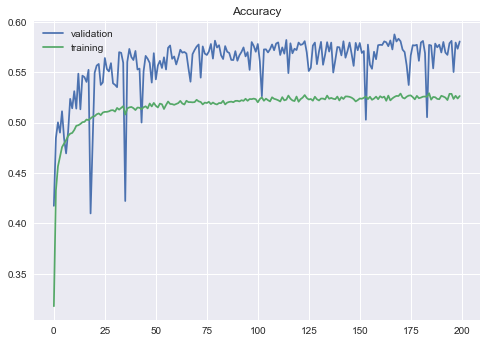

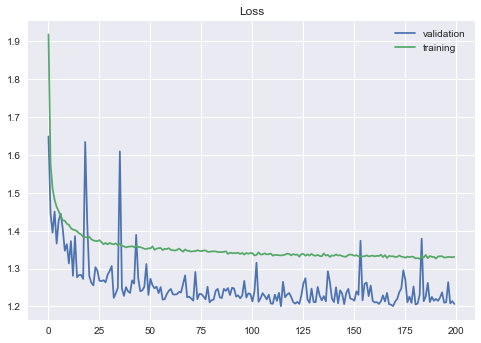

In [44]:
x_axis = list(range(200))

plt.clf() 
plt.plot(x_axis, batch_norm['val_acc'] [0:200], label='validation')
plt.plot(x_axis, batch_norm['acc'] [0:200], label='training')
plt.legend()
plt.title('Accuracy')
plt.show()


plt.clf() 
plt.plot(x_axis, batch_norm['val_loss'] [0:200], label='validation')
plt.plot(x_axis, batch_norm['loss'] [0:200], label='training')
plt.legend()
plt.title('Loss')
plt.show()

In [65]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()

In [66]:
model = None

# Add your code to complete this cell

model_name = 'batch_norm2'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
# ====================================================   
input_im = Input(shape=(input_shape), name='input_im')

conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
batchnorm1 = BatchNormalization()(conv1)
dropout1 = Dropout(0.3)(batchnorm1)
pooling1 = AveragePooling2D(pool_size=(2,2))(dropout1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pooling1)
batchnorm2 = BatchNormalization()(conv2)
dropout3 = Dropout(0.2)(batchnorm2)
flat = Flatten()(dropout3)
#dense1 = Dense(44, activation='relu')(flat)

output_class = Dense(num_classes, activation='softmax')(flat)
model = Model(inputs=input_im, outputs=output_class)
# ====================================================

adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
#plot_model(model, model_name+'/'+model_name+'.png')
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 8)         32        
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 8)         0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 16)          64        
__________

In [17]:
hist_batchnorm = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

model.save(model_name + '.h5')

Epoch 1/200
2500/2500 [==============================] - 45s 18ms/step - loss: 1.9180 - acc: 0.3179 - val_loss: 1.6489 - val_acc: 0.4174

Epoch 00001: val_loss improved from inf to 1.64887, saving model to batch_norm2/batch_norm2-01-1.65.h5
Epoch 2/200
2500/2500 [==============================] - 35s 14ms/step - loss: 1.5762 - acc: 0.4326 - val_loss: 1.4465 - val_acc: 0.4846

Epoch 00002: val_loss improved from 1.64887 to 1.44646, saving model to batch_norm2/batch_norm2-02-1.45.h5
Epoch 3/200
2500/2500 [==============================] - 38s 15ms/step - loss: 1.5106 - acc: 0.4565 - val_loss: 1.3948 - val_acc: 0.5002

Epoch 00003: val_loss improved from 1.44646 to 1.39476, saving model to batch_norm2/batch_norm2-03-1.39.h5
Epoch 4/200
2500/2500 [==============================] - 38s 15ms/step - loss: 1.4816 - acc: 0.4661 - val_loss: 1.4505 - val_acc: 0.4900

Epoch 00004: val_loss did not improve from 1.39476
Epoch 5/200
2500/2500 [==============================] - 28s 11ms/step - loss: 1


Epoch 00040: val_loss did not improve from 1.22270
Epoch 41/200
2500/2500 [==============================] - 38s 15ms/step - loss: 1.3578 - acc: 0.5124 - val_loss: 1.2358 - val_acc: 0.5710

Epoch 00041: val_loss did not improve from 1.22270
Epoch 42/200
2500/2500 [==============================] - 37s 15ms/step - loss: 1.3592 - acc: 0.5149 - val_loss: 1.2690 - val_acc: 0.5526

Epoch 00042: val_loss did not improve from 1.22270
Epoch 43/200
2500/2500 [==============================] - 33s 13ms/step - loss: 1.3566 - acc: 0.5147 - val_loss: 1.2606 - val_acc: 0.5535

Epoch 00043: val_loss did not improve from 1.22270
Epoch 44/200
2500/2500 [==============================] - 40s 16ms/step - loss: 1.3606 - acc: 0.5132 - val_loss: 1.3889 - val_acc: 0.5000

Epoch 00044: val_loss did not improve from 1.22270
Epoch 45/200
2500/2500 [==============================] - 47s 19ms/step - loss: 1.3569 - acc: 0.5152 - val_loss: 1.2747 - val_acc: 0.5509

Epoch 00045: val_loss did not improve from 1.2227

2500/2500 [==============================] - 25s 10ms/step - loss: 1.3455 - acc: 0.5192 - val_loss: 1.2417 - val_acc: 0.5667

Epoch 00083: val_loss did not improve from 1.21108
Epoch 84/200
2500/2500 [==============================] - 25s 10ms/step - loss: 1.3437 - acc: 0.5216 - val_loss: 1.2464 - val_acc: 0.5630

Epoch 00084: val_loss did not improve from 1.21108
Epoch 85/200
2500/2500 [==============================] - 25s 10ms/step - loss: 1.3435 - acc: 0.5180 - val_loss: 1.2240 - val_acc: 0.5758

Epoch 00085: val_loss did not improve from 1.21108
Epoch 86/200
2500/2500 [==============================] - 25s 10ms/step - loss: 1.3436 - acc: 0.5198 - val_loss: 1.2222 - val_acc: 0.5702

Epoch 00086: val_loss did not improve from 1.21108
Epoch 87/200
2500/2500 [==============================] - 25s 10ms/step - loss: 1.3442 - acc: 0.5205 - val_loss: 1.2466 - val_acc: 0.5690

Epoch 00087: val_loss did not improve from 1.21108
Epoch 88/200
2500/2500 [==============================] - 26s 1

2500/2500 [==============================] - 46s 18ms/step - loss: 1.3335 - acc: 0.5254 - val_loss: 1.2062 - val_acc: 0.5874

Epoch 00168: val_loss did not improve from 1.20072
Epoch 169/200
2500/2500 [==============================] - 46s 18ms/step - loss: 1.3324 - acc: 0.5264 - val_loss: 1.2045 - val_acc: 0.5804

Epoch 00169: val_loss did not improve from 1.20072
Epoch 170/200
2500/2500 [==============================] - 46s 18ms/step - loss: 1.3327 - acc: 0.5263 - val_loss: 1.2010 - val_acc: 0.5831

Epoch 00170: val_loss did not improve from 1.20072
Epoch 171/200
2500/2500 [==============================] - 46s 18ms/step - loss: 1.3305 - acc: 0.5287 - val_loss: 1.2132 - val_acc: 0.5806

Epoch 00171: val_loss did not improve from 1.20072
Epoch 172/200
2500/2500 [==============================] - 46s 18ms/step - loss: 1.3311 - acc: 0.5248 - val_loss: 1.2197 - val_acc: 0.5723

Epoch 00172: val_loss did not improve from 1.20072
Epoch 173/200
2500/2500 [==============================] - 

##### Task 5.1 Comparision of all model

In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why.   

In [46]:
simple_model = pd.read_csv('simple_model/logs.csv')
pre_norm = pd.read_csv('pre_norm/logs.csv')
pooling = pd.read_csv('pooling/logs.csv')
dropout = pd.read_csv('dropout/logs.csv')
batch_norm = pd.read_csv('batch_norm/logs.csv')

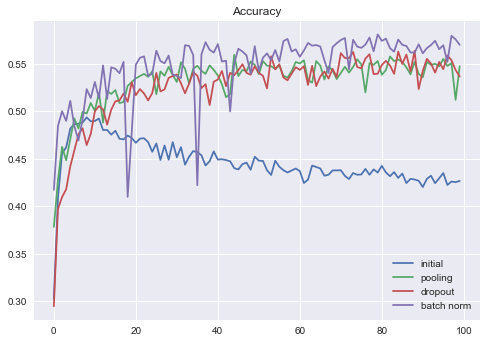

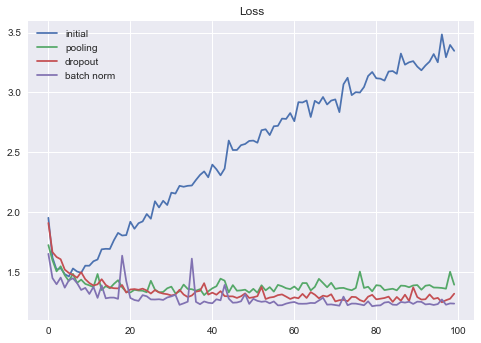

In [48]:
x_axis = list(range(100))

plt.clf() 
plt.plot(x_axis, simple_model['val_acc'][0:100], label='initial')
#plt.plot(x_axis, pre_norm['val_acc'][0:100], label='preprocess')
plt.plot(x_axis, pooling['val_acc'][0:100], label='pooling')
plt.plot(x_axis, dropout['val_acc'][0:100], label='dropout')
plt.plot(x_axis, batch_norm['val_acc'][0:100], label='batch norm')
plt.legend()
plt.title('Accuracy')
plt.show()


plt.clf() 
plt.plot(x_axis, simple_model['val_loss'][0:100], label='initial')
#plt.plot(x_axis, pre_norm['val_loss'][0:100], label='preprocess')
plt.plot(x_axis, pooling['val_loss'][0:100], label='pooling')
plt.plot(x_axis, dropout['val_loss'][0:100], label='dropout')
plt.plot(x_axis, batch_norm['val_loss'][0:100], label='batch norm')
plt.legend()
plt.title('Loss')
plt.show()

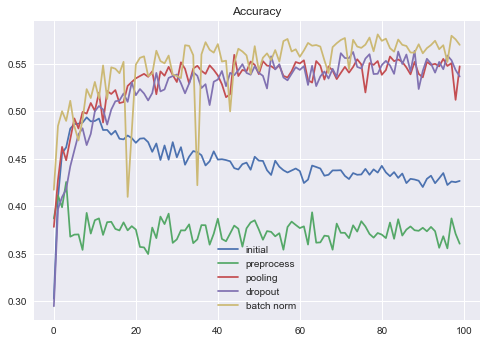

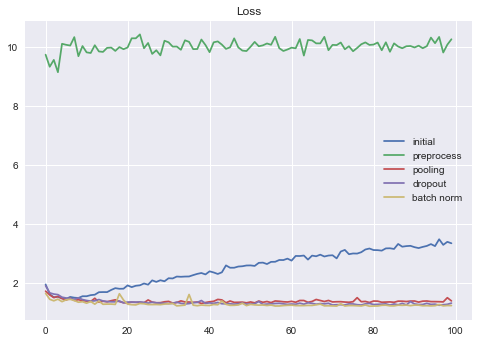

In [50]:
x_axis = list(range(100))

plt.clf() 
plt.plot(x_axis, simple_model['val_acc'][0:100], label='initial')
plt.plot(x_axis, pre_norm['val_acc'][0:100], label='preprocess')
plt.plot(x_axis, pooling['val_acc'][0:100], label='pooling')
plt.plot(x_axis, dropout['val_acc'][0:100], label='dropout')
plt.plot(x_axis, batch_norm['val_acc'][0:100], label='batch norm')
plt.legend()
plt.title('Accuracy')
plt.show()


plt.clf() 
plt.plot(x_axis, simple_model['val_loss'][0:100], label='initial')
plt.plot(x_axis, pre_norm['val_loss'][0:100], label='preprocess')
plt.plot(x_axis, pooling['val_loss'][0:100], label='pooling')
plt.plot(x_axis, dropout['val_loss'][0:100], label='dropout')
plt.plot(x_axis, batch_norm['val_loss'][0:100], label='batch norm')
plt.legend()
plt.title('Loss')
plt.show()

###### Tensorboard 

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

- Tensorboard plot of accuracies:
!['loss'](loss.png)

- Tensorboard plot of accuracies:
!['Accuracy](acc.png)


###### ADD Your Comments here

##### Task 5.2 Visualize Activations
In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model. For help, please refer to __Tutorials__

#### Conv layer 1

In [69]:
new_model = Model(inputs=input_im, 
                  outputs=model.get_layer('conv2d_5').output)

In [70]:
val_gen = data_generator(x_val, y_val, batch_size)
x = next(val_gen)
i = x[0]
image = i[0]
image.shape

(32, 32, 3)

In [71]:
shape = (1,32,32,3)
y = image.reshape(shape)

In [72]:
con1_activations = new_model.predict(y)
con1_activations.shape

(1, 15, 15, 8)

IndexError: index 8 is out of bounds for axis 3 with size 8

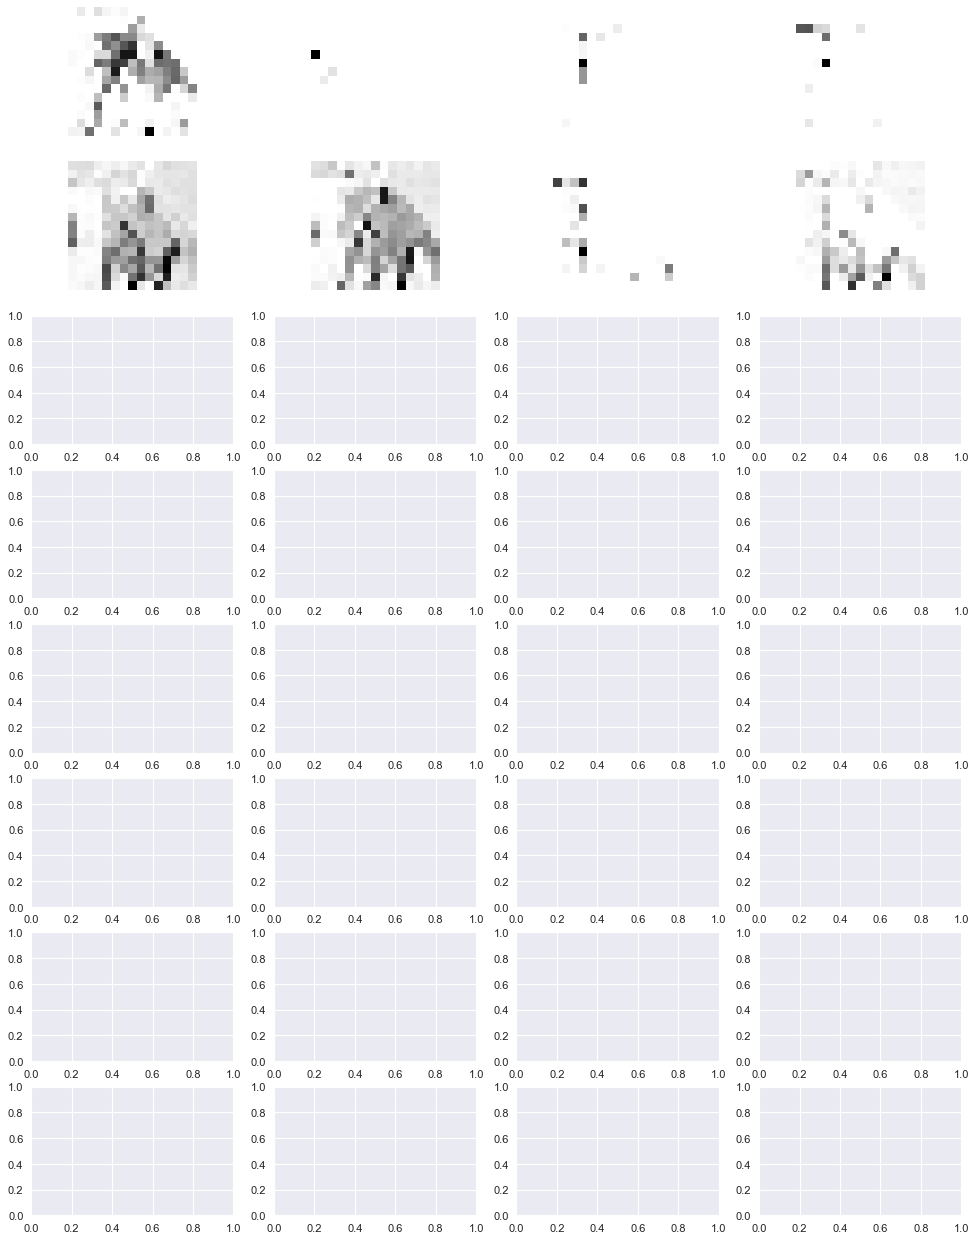

In [73]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,20), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(con1_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

#### Conv layer 2

In [74]:
new_model = Model(inputs=input_im, 
                  outputs=model.get_layer('conv2d_6').output)

In [75]:
val_gen = data_generator(x_val, y_val, batch_size)
x = next(val_gen)
i = x[0]
image = i[0]
image.shape

(32, 32, 3)

In [76]:
shape = (1,32,32,3)
y = image.reshape(shape)

In [77]:
con1_activations = new_model.predict(y)
con1_activations.shape

(1, 3, 3, 16)

IndexError: index 16 is out of bounds for axis 3 with size 16

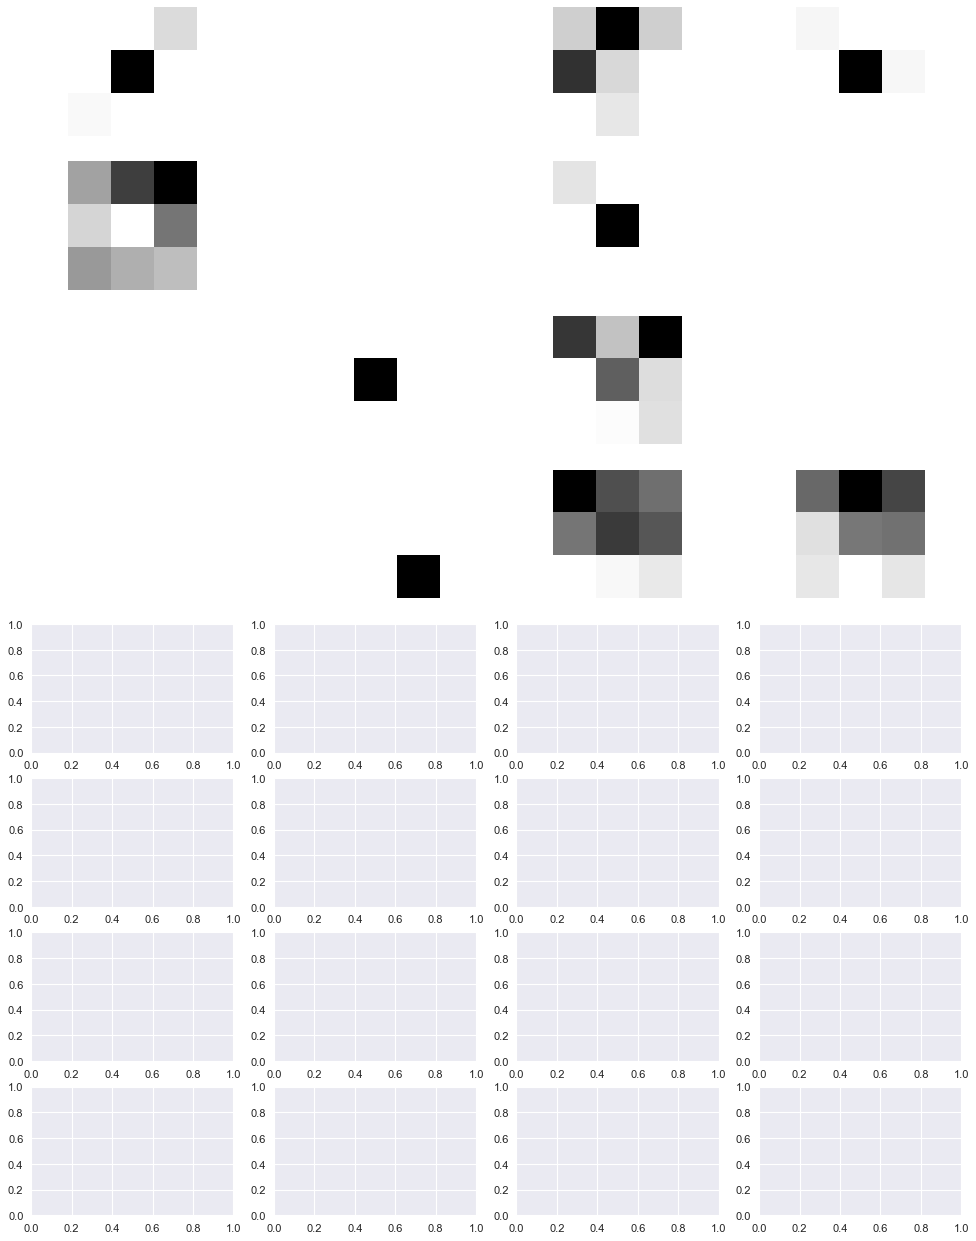

In [78]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,20), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(con1_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

## Task 6.1  Effect of learning rate

Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [3]:
epochs = 200

### 6.1.3 learning rate = 0.00001

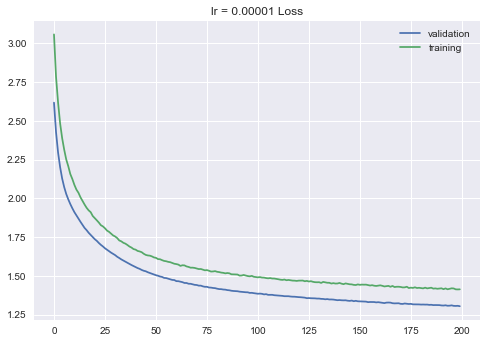

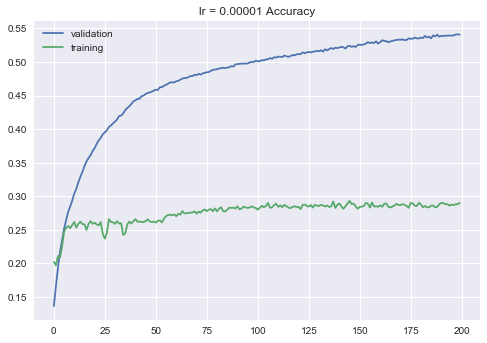

In [54]:
x_axis = list(range(epochs))

plt.clf()
plt.plot(x_axis, min_lr_model['val_loss'],  label='validation')
plt.plot(x_axis, min_lr_model['loss'],  label='training')
plt.legend()
plt.title('lr = 0.00001 Loss')
plt.show()

plt.clf()
plt.plot(x_axis, min_lr_model['val_acc'],  label='validation')
plt.plot(x_axis, mid_lr_model['acc'],  label='training')
plt.legend()
plt.title('lr = 0.00001 Accuracy')
plt.show()


In [23]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()

In [24]:
model = None

# Add your code to complete this cell

model_name = 'lr_min'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
# ====================================================   
input_im = Input(shape=(input_shape), name='input_im')

conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
batchnorm1 = BatchNormalization()(conv1)
dropout1 = Dropout(0.3)(batchnorm1)
pooling1 = AveragePooling2D(pool_size=(2,2))(dropout1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pooling1)
batchnorm2 = BatchNormalization()(conv2)
dropout3 = Dropout(0.2)(batchnorm2)
flat = Flatten()(dropout3)
#dense1 = Dense(44, activation='relu')(flat)

output_class = Dense(num_classes, activation='softmax')(flat)
model = Model(inputs=input_im, outputs=output_class)
# ====================================================

adam = Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
#plot_model(model, model_name+'/'+model_name+'.png')
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 15, 8)         32        
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 8)         0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 3, 16)          64        
__________

In [25]:
hist_lr_min = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

model.save(model_name + '.h5')

Epoch 1/200
2500/2500 [==============================] - 36s 14ms/step - loss: 3.0579 - acc: 0.1100 - val_loss: 2.6175 - val_acc: 0.1364

Epoch 00001: val_loss did not improve from 2.48709
Epoch 2/200
2500/2500 [==============================] - 36s 14ms/step - loss: 2.7845 - acc: 0.1364 - val_loss: 2.4270 - val_acc: 0.1660

Epoch 00002: val_loss improved from 2.48709 to 2.42699, saving model to lr_min/lr_min-02-2.43.h5
Epoch 3/200
2500/2500 [==============================] - 35s 14ms/step - loss: 2.6183 - acc: 0.1582 - val_loss: 2.2956 - val_acc: 0.1936

Epoch 00003: val_loss improved from 2.42699 to 2.29564, saving model to lr_min/lr_min-03-2.30.h5
Epoch 4/200
2500/2500 [==============================] - 26s 10ms/step - loss: 2.4841 - acc: 0.1810 - val_loss: 2.2017 - val_acc: 0.2171

Epoch 00004: val_loss improved from 2.29564 to 2.20172, saving model to lr_min/lr_min-04-2.20.h5
Epoch 5/200
2500/2500 [==============================] - 26s 10ms/step - loss: 2.3887 - acc: 0.1940 - val_

2500/2500 [==============================] - 36s 15ms/step - loss: 1.7075 - acc: 0.3779 - val_loss: 1.5914 - val_acc: 0.4284

Epoch 00036: val_loss improved from 1.59842 to 1.59142, saving model to lr_min/lr_min-36-1.59.h5
Epoch 37/200
2500/2500 [==============================] - 37s 15ms/step - loss: 1.6988 - acc: 0.3796 - val_loss: 1.5845 - val_acc: 0.4314

Epoch 00037: val_loss improved from 1.59142 to 1.58446, saving model to lr_min/lr_min-37-1.58.h5
Epoch 38/200
2500/2500 [==============================] - 37s 15ms/step - loss: 1.6888 - acc: 0.3868 - val_loss: 1.5761 - val_acc: 0.4341

Epoch 00038: val_loss improved from 1.58446 to 1.57613, saving model to lr_min/lr_min-38-1.58.h5
Epoch 39/200
2500/2500 [==============================] - 37s 15ms/step - loss: 1.6821 - acc: 0.3912 - val_loss: 1.5693 - val_acc: 0.4376

Epoch 00039: val_loss improved from 1.57613 to 1.56934, saving model to lr_min/lr_min-39-1.57.h5
Epoch 40/200
2500/2500 [==============================] - 37s 15ms/st

2500/2500 [==============================] - 41s 17ms/step - loss: 1.5469 - acc: 0.4418 - val_loss: 1.4404 - val_acc: 0.4804

Epoch 00071: val_loss improved from 1.44142 to 1.44040, saving model to lr_min/lr_min-71-1.44.h5
Epoch 72/200
2500/2500 [==============================] - 41s 16ms/step - loss: 1.5433 - acc: 0.4434 - val_loss: 1.4363 - val_acc: 0.4824

Epoch 00072: val_loss improved from 1.44040 to 1.43630, saving model to lr_min/lr_min-72-1.44.h5
Epoch 73/200
2500/2500 [==============================] - 41s 17ms/step - loss: 1.5438 - acc: 0.4449 - val_loss: 1.4364 - val_acc: 0.4812

Epoch 00073: val_loss did not improve from 1.43630
Epoch 74/200
2500/2500 [==============================] - 41s 17ms/step - loss: 1.5397 - acc: 0.4447 - val_loss: 1.4316 - val_acc: 0.4830

Epoch 00074: val_loss improved from 1.43630 to 1.43162, saving model to lr_min/lr_min-74-1.43.h5
Epoch 75/200
2500/2500 [==============================] - 42s 17ms/step - loss: 1.5352 - acc: 0.4508 - val_loss: 1.

2500/2500 [==============================] - 39s 16ms/step - loss: 1.4853 - acc: 0.4656 - val_loss: 1.3770 - val_acc: 0.5059

Epoch 00107: val_loss did not improve from 1.37696
Epoch 108/200
2500/2500 [==============================] - 38s 15ms/step - loss: 1.4823 - acc: 0.4697 - val_loss: 1.3771 - val_acc: 0.5047

Epoch 00108: val_loss did not improve from 1.37696
Epoch 109/200
2500/2500 [==============================] - 39s 16ms/step - loss: 1.4822 - acc: 0.4657 - val_loss: 1.3745 - val_acc: 0.5072

Epoch 00109: val_loss improved from 1.37696 to 1.37452, saving model to lr_min/lr_min-109-1.37.h5
Epoch 110/200
2500/2500 [==============================] - 39s 16ms/step - loss: 1.4802 - acc: 0.4702 - val_loss: 1.3735 - val_acc: 0.5066

Epoch 00110: val_loss improved from 1.37452 to 1.37349, saving model to lr_min/lr_min-110-1.37.h5
Epoch 111/200
2500/2500 [==============================] - 39s 16ms/step - loss: 1.4776 - acc: 0.4693 - val_loss: 1.3724 - val_acc: 0.5080

Epoch 00111: val

2500/2500 [==============================] - 29s 11ms/step - loss: 1.4203 - acc: 0.4936 - val_loss: 1.3141 - val_acc: 0.5363

Epoch 00181: val_loss improved from 1.31512 to 1.31405, saving model to lr_min/lr_min-181-1.31.h5
Epoch 182/200
2500/2500 [==============================] - 29s 11ms/step - loss: 1.4186 - acc: 0.4955 - val_loss: 1.3145 - val_acc: 0.5357

Epoch 00182: val_loss did not improve from 1.31405
Epoch 183/200
2500/2500 [==============================] - 29s 12ms/step - loss: 1.4233 - acc: 0.4929 - val_loss: 1.3138 - val_acc: 0.5390

Epoch 00183: val_loss improved from 1.31405 to 1.31384, saving model to lr_min/lr_min-183-1.31.h5
Epoch 184/200
2500/2500 [==============================] - 29s 11ms/step - loss: 1.4187 - acc: 0.4921 - val_loss: 1.3141 - val_acc: 0.5364

Epoch 00184: val_loss did not improve from 1.31384
Epoch 185/200
2500/2500 [==============================] - 29s 11ms/step - loss: 1.4205 - acc: 0.4933 - val_loss: 1.3122 - val_acc: 0.5378

Epoch 00185: val

### 6.1.2 learning rate = any value between 0.6 and 0.1

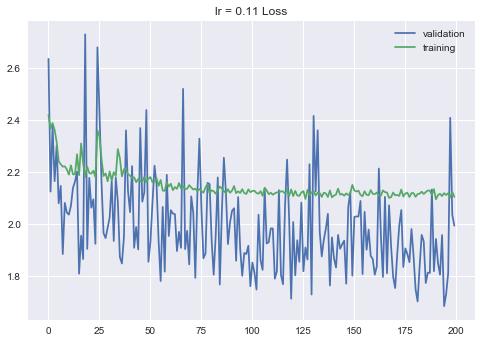

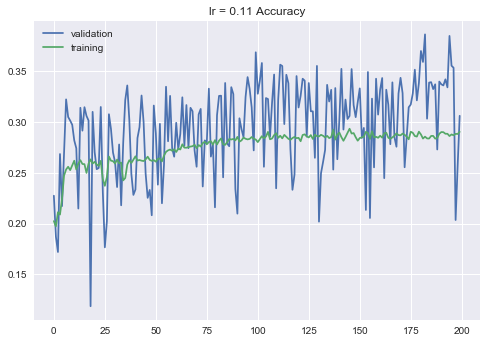

In [55]:
x_axis = list(range(epochs))

plt.clf()
plt.plot(x_axis, mid_lr_model['val_loss'],  label='validation')
plt.plot(x_axis, mid_lr_model['loss'],  label='training')
plt.legend()
plt.title('lr = 0.11 Loss')
plt.show()

plt.clf()
plt.plot(x_axis, mid_lr_model['val_acc'],  label='validation')
plt.plot(x_axis, mid_lr_model['acc'],  label='training')
plt.legend()
plt.title('lr = 0.11 Accuracy')
plt.show()


In [19]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()

In [20]:
model = None

# Add your code to complete this cell

model_name = 'lr_mid'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
# ====================================================   
input_im = Input(shape=(input_shape), name='input_im')

conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
batchnorm1 = BatchNormalization()(conv1)
dropout1 = Dropout(0.3)(batchnorm1)
pooling1 = AveragePooling2D(pool_size=(2,2))(dropout1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pooling1)
batchnorm2 = BatchNormalization()(conv2)
dropout3 = Dropout(0.2)(batchnorm2)
flat = Flatten()(dropout3)
#dense1 = Dense(44, activation='relu')(flat)

output_class = Dense(num_classes, activation='softmax')(flat)
model = Model(inputs=input_im, outputs=output_class)
# ====================================================

adam = Adam(lr=0.11)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
#plot_model(model, model_name+'/'+model_name+'.png')
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 15, 8)         32        
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 8)         0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 3, 16)          64        
__________

In [21]:
hist_lr_mid = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

model.save(model_name + '.h5')

Epoch 1/200
2500/2500 [==============================] - 35s 14ms/step - loss: 2.4203 - acc: 0.2024 - val_loss: 2.6361 - val_acc: 0.2274

Epoch 00001: val_loss improved from 14.43537 to 2.63608, saving model to lr_mid/lr_mid-01-2.64.h5
Epoch 2/200
2500/2500 [==============================] - 37s 15ms/step - loss: 2.3682 - acc: 0.1973 - val_loss: 2.1251 - val_acc: 0.1871

Epoch 00002: val_loss improved from 2.63608 to 2.12513, saving model to lr_mid/lr_mid-02-2.13.h5
Epoch 3/200
2500/2500 [==============================] - 33s 13ms/step - loss: 2.3890 - acc: 0.2112 - val_loss: 2.3781 - val_acc: 0.1720

Epoch 00003: val_loss did not improve from 2.12513
Epoch 4/200
2500/2500 [==============================] - 36s 14ms/step - loss: 2.3626 - acc: 0.2088 - val_loss: 2.1651 - val_acc: 0.2684

Epoch 00004: val_loss did not improve from 2.12513
Epoch 5/200
2500/2500 [==============================] - 36s 14ms/step - loss: 2.3161 - acc: 0.2245 - val_loss: 2.3021 - val_acc: 0.2172

Epoch 00005: 

2500/2500 [==============================] - 41s 17ms/step - loss: 2.1801 - acc: 0.2625 - val_loss: 1.9083 - val_acc: 0.2949

Epoch 00043: val_loss did not improve from 1.80892
Epoch 44/200
2500/2500 [==============================] - 39s 15ms/step - loss: 2.1613 - acc: 0.2619 - val_loss: 1.9885 - val_acc: 0.3260

Epoch 00044: val_loss did not improve from 1.80892
Epoch 45/200
2500/2500 [==============================] - 29s 12ms/step - loss: 2.1735 - acc: 0.2615 - val_loss: 1.9025 - val_acc: 0.2999

Epoch 00045: val_loss did not improve from 1.80892
Epoch 46/200
2500/2500 [==============================] - 29s 12ms/step - loss: 2.1656 - acc: 0.2631 - val_loss: 2.3698 - val_acc: 0.2492

Epoch 00046: val_loss did not improve from 1.80892
Epoch 47/200
2500/2500 [==============================] - 29s 12ms/step - loss: 2.1644 - acc: 0.2658 - val_loss: 2.0862 - val_acc: 0.2253

Epoch 00047: val_loss did not improve from 1.80892
Epoch 48/200
2500/2500 [==============================] - 29s 1

2500/2500 [==============================] - 29s 12ms/step - loss: 2.1370 - acc: 0.2800 - val_loss: 2.0447 - val_acc: 0.2787

Epoch 00086: val_loss did not improve from 1.76724
Epoch 87/200
2500/2500 [==============================] - 29s 11ms/step - loss: 2.1273 - acc: 0.2832 - val_loss: 2.2553 - val_acc: 0.2761

Epoch 00087: val_loss did not improve from 1.76724
Epoch 88/200
2500/2500 [==============================] - 29s 11ms/step - loss: 2.1184 - acc: 0.2827 - val_loss: 2.1208 - val_acc: 0.3342

Epoch 00088: val_loss did not improve from 1.76724
Epoch 89/200
2500/2500 [==============================] - 29s 11ms/step - loss: 2.1343 - acc: 0.2833 - val_loss: 1.9227 - val_acc: 0.3274

Epoch 00089: val_loss did not improve from 1.76724
Epoch 90/200
2500/2500 [==============================] - 29s 11ms/step - loss: 2.1203 - acc: 0.2818 - val_loss: 2.0056 - val_acc: 0.2341

Epoch 00090: val_loss did not improve from 1.76724
Epoch 91/200
2500/2500 [==============================] - 29s 1

2500/2500 [==============================] - 29s 12ms/step - loss: 2.1107 - acc: 0.2868 - val_loss: 1.7534 - val_acc: 0.3434

Epoch 00171: val_loss did not improve from 1.71252
Epoch 172/200
2500/2500 [==============================] - 29s 12ms/step - loss: 2.1122 - acc: 0.2885 - val_loss: 1.8829 - val_acc: 0.3283

Epoch 00172: val_loss did not improve from 1.71252
Epoch 173/200
2500/2500 [==============================] - 29s 12ms/step - loss: 2.1085 - acc: 0.2873 - val_loss: 1.9934 - val_acc: 0.2554

Epoch 00173: val_loss did not improve from 1.71252
Epoch 174/200
2500/2500 [==============================] - 29s 12ms/step - loss: 2.1330 - acc: 0.2856 - val_loss: 2.0540 - val_acc: 0.2857

Epoch 00174: val_loss did not improve from 1.71252
Epoch 175/200
2500/2500 [==============================] - 29s 12ms/step - loss: 2.1060 - acc: 0.2829 - val_loss: 1.8346 - val_acc: 0.3144

Epoch 00175: val_loss did not improve from 1.71252
Epoch 176/200
2500/2500 [==============================] - 

In [23]:
data_tuples = list(zip(hist_lr_mid.history['acc'], hist_lr_mid.history['loss'], hist_lr_mid.history['val_acc'], hist_lr_mid.history['val_loss']))
df = pd.DataFrame(data_tuples, columns=['acc','loss','val_acc','val_loss'])
df.to_csv('logs1.csv', encoding='utf-8')

#### 6.1.1 any value between 5 and 1.

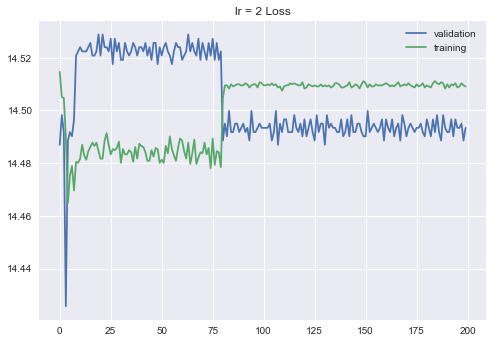

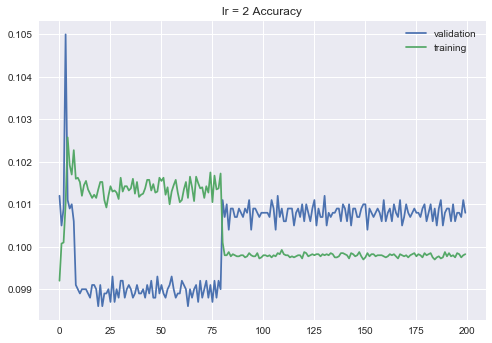

In [56]:
x_axis = list(range(epochs))

plt.clf()
plt.plot(x_axis, max_lr_model['val_loss'],  label='validation')
plt.plot(x_axis, max_lr_model['loss'],  label='training')
plt.legend()
plt.title('lr = 2 Loss')
plt.show()

plt.clf()
plt.plot(x_axis, max_lr_model['val_acc'],  label='validation')
plt.plot(x_axis, max_lr_model['acc'],  label='training')
plt.legend()
plt.title('lr = 2 Accuracy')
plt.show()


In [17]:
train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size)
#test_gen = data_generator(x_test, y_test, batch_size)

x,y= val_gen.__next__()

In [18]:
model = None

# Add your code to complete this cell

model_name = 'lr_max'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    
# ====================================================   
input_im = Input(shape=(input_shape), name='input_im')

conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_im)
batchnorm1 = BatchNormalization()(conv1)
dropout1 = Dropout(0.3)(batchnorm1)
pooling1 = AveragePooling2D(pool_size=(2,2))(dropout1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pooling1)
batchnorm2 = BatchNormalization()(conv2)
dropout3 = Dropout(0.2)(batchnorm2)
flat = Flatten()(dropout3)
#dense1 = Dense(44, activation='relu')(flat)

output_class = Dense(num_classes, activation='softmax')(flat)
model = Model(inputs=input_im, outputs=output_class)
# ====================================================

adam = Adam(lr=2)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
#plot_model(model, model_name+'/'+model_name+'.png')
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 8)         32        
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 8)         0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 16)          64        
__________

In [19]:
hist_lr_max = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

model.save(model_name + '.h5')

Epoch 1/200
2500/2500 [==============================] - 43s 17ms/step - loss: 14.5147 - acc: 0.0992 - val_loss: 14.4869 - val_acc: 0.1012

Epoch 00001: val_loss improved from inf to 14.48694, saving model to lr_max/lr_max-01-14.49.h5
Epoch 2/200
2500/2500 [==============================] - 38s 15ms/step - loss: 14.5051 - acc: 0.1001 - val_loss: 14.4982 - val_acc: 0.1005

Epoch 00002: val_loss did not improve from 14.48694
Epoch 3/200
2500/2500 [==============================] - 36s 14ms/step - loss: 14.5047 - acc: 0.1001 - val_loss: 14.4918 - val_acc: 0.1009

Epoch 00003: val_loss did not improve from 14.48694
Epoch 4/200
2500/2500 [==============================] - 36s 14ms/step - loss: 14.4898 - acc: 0.1010 - val_loss: 14.4257 - val_acc: 0.1050

Epoch 00004: val_loss improved from 14.48694 to 14.42570, saving model to lr_max/lr_max-04-14.43.h5
Epoch 5/200
2500/2500 [==============================] - 36s 14ms/step - loss: 14.4648 - acc: 0.1026 - val_loss: 14.4886 - val_acc: 0.1011

E

2500/2500 [==============================] - 36s 14ms/step - loss: 14.4841 - acc: 0.1014 - val_loss: 14.5256 - val_acc: 0.0988

Epoch 00043: val_loss did not improve from 14.42570
Epoch 44/200
2500/2500 [==============================] - 36s 14ms/step - loss: 14.4809 - acc: 0.1016 - val_loss: 14.5208 - val_acc: 0.0991

Epoch 00044: val_loss did not improve from 14.42570
Epoch 45/200
2500/2500 [==============================] - 36s 14ms/step - loss: 14.4809 - acc: 0.1016 - val_loss: 14.5240 - val_acc: 0.0989

Epoch 00045: val_loss did not improve from 14.42570
Epoch 46/200
2500/2500 [==============================] - 37s 15ms/step - loss: 14.4849 - acc: 0.1013 - val_loss: 14.5192 - val_acc: 0.0992

Epoch 00046: val_loss did not improve from 14.42570
Epoch 47/200
2500/2500 [==============================] - 42s 17ms/step - loss: 14.4825 - acc: 0.1015 - val_loss: 14.5256 - val_acc: 0.0988

Epoch 00047: val_loss did not improve from 14.42570
Epoch 48/200
2500/2500 [========================


Epoch 00085: val_loss did not improve from 14.42570
Epoch 86/200
2500/2500 [==============================] - 39s 15ms/step - loss: 14.5091 - acc: 0.0998 - val_loss: 14.4918 - val_acc: 0.1009

Epoch 00086: val_loss did not improve from 14.42570
Epoch 87/200
2500/2500 [==============================] - 39s 16ms/step - loss: 14.5095 - acc: 0.0998 - val_loss: 14.4950 - val_acc: 0.1007

Epoch 00087: val_loss did not improve from 14.42570
Epoch 88/200
2500/2500 [==============================] - 39s 16ms/step - loss: 14.5099 - acc: 0.0998 - val_loss: 14.4950 - val_acc: 0.1007

Epoch 00088: val_loss did not improve from 14.42570
Epoch 89/200
2500/2500 [==============================] - 39s 16ms/step - loss: 14.5099 - acc: 0.0998 - val_loss: 14.4918 - val_acc: 0.1009

Epoch 00089: val_loss did not improve from 14.42570
Epoch 90/200
2500/2500 [==============================] - 33s 13ms/step - loss: 14.5095 - acc: 0.0998 - val_loss: 14.4934 - val_acc: 0.1008

Epoch 00090: val_loss did not impr

2500/2500 [==============================] - 28s 11ms/step - loss: 14.5091 - acc: 0.0998 - val_loss: 14.4918 - val_acc: 0.1009

Epoch 00128: val_loss did not improve from 14.42570
Epoch 129/200
2500/2500 [==============================] - 28s 11ms/step - loss: 14.5099 - acc: 0.0998 - val_loss: 14.4950 - val_acc: 0.1007

Epoch 00129: val_loss did not improve from 14.42570
Epoch 130/200
2500/2500 [==============================] - 28s 11ms/step - loss: 14.5091 - acc: 0.0998 - val_loss: 14.4950 - val_acc: 0.1007

Epoch 00130: val_loss did not improve from 14.42570
Epoch 131/200
2500/2500 [==============================] - 28s 11ms/step - loss: 14.5095 - acc: 0.0998 - val_loss: 14.4869 - val_acc: 0.1012

Epoch 00131: val_loss did not improve from 14.42570
Epoch 132/200
2500/2500 [==============================] - 28s 11ms/step - loss: 14.5091 - acc: 0.0998 - val_loss: 14.4982 - val_acc: 0.1005

Epoch 00132: val_loss did not improve from 14.42570
Epoch 133/200
2500/2500 [===================

In [ ]:
#if need to make csv

data_tuples = list(zip(hist_lr_mid.history['acc'], hist_lr_mid.history['loss'], hist_lr_mid.history['val_acc'], hist_lr_mid.history['val_loss']))
df = pd.DataFrame(data_tuples, columns=['acc','loss','val_acc','val_loss'])
df.to_csv('logs1.csv', encoding='utf-8')

###### Task 6.2 Plot loss and accuracy

Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

best_model = pd.read_csv('batch_norm/logs.csv')
min_lr_model = pd.read_csv('lr_min/logs.csv')
mid_lr_model = pd.read_csv('lr_mid/logs.csv')
max_lr_model = pd.read_csv('lr_max/logs.csv')


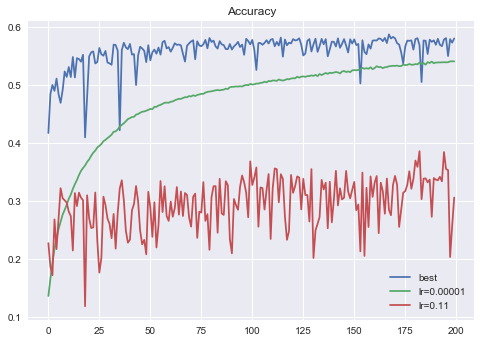

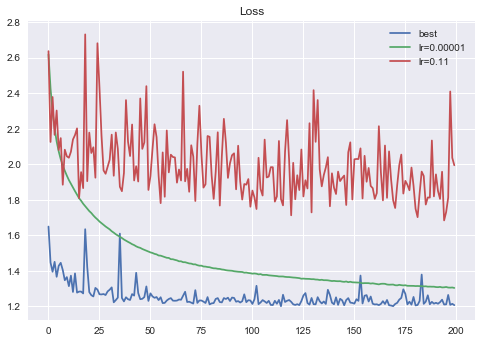

In [53]:
epochs = 200
x_axis = list(range(epochs))

plt.clf() 
plt.plot(x_axis, best_model['val_acc'], label='best')
plt.plot(x_axis, min_lr_model['val_acc'], label='lr=0.00001')
plt.plot(x_axis, mid_lr_model['val_acc'], label='lr=0.11')
#plt.plot(x_axis, max_lr_model['val_acc'], label='lr=2')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.clf() 
x_axis = list(range(epochs))
plt.plot(x_axis, best_model['val_loss'],  label='best')
plt.plot(x_axis, min_lr_model['val_loss'], label='lr=0.00001')
plt.plot(x_axis, mid_lr_model['val_loss'], label='lr=0.11')
#plt.plot(x_axis, max_lr_model['val_loss'], label='lr=2')
plt.legend()
plt.title('Loss')
plt.show()

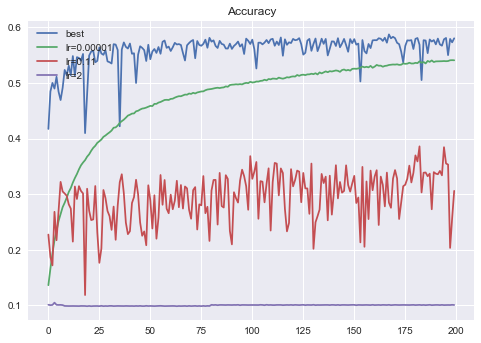

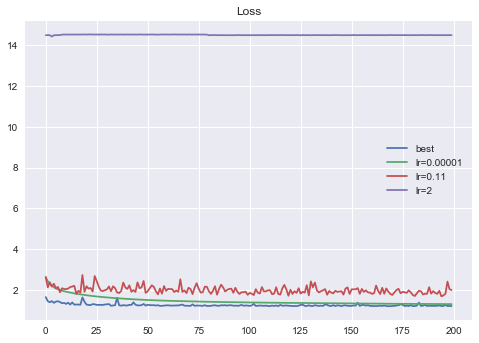

In [57]:
epochs = 200
x_axis = list(range(epochs))

plt.clf() 
plt.plot(x_axis, best_model['val_acc'], label='best')
plt.plot(x_axis, min_lr_model['val_acc'], label='lr=0.00001')
plt.plot(x_axis, mid_lr_model['val_acc'], label='lr=0.11')
plt.plot(x_axis, max_lr_model['val_acc'], label='lr=2')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.clf() 
x_axis = list(range(epochs))
plt.plot(x_axis, best_model['val_loss'],  label='best')
plt.plot(x_axis, min_lr_model['val_loss'], label='lr=0.00001')
plt.plot(x_axis, mid_lr_model['val_loss'], label='lr=0.11')
plt.plot(x_axis, max_lr_model['val_loss'], label='lr=2')
plt.legend()
plt.title('Loss')
plt.show()